In [1]:
import pandas as pd
import seaborn as sns
import optuna
import numpy as np
import itertools
import dill

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, classification_report
from matplotlib import pyplot as plt
from optuna.pruners import HyperbandPruner
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

In [26]:
import warnings
warnings.filterwarnings("ignore")

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
df_final = pd.read_parquet('train_data/df_final.parquet')
print(df_final.shape)
df_final.head()

(3000000, 361)


,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,...,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_infrequent_sklearn,flag
0,0,10,0.900000,1.000000,1.000000,1.000000,1.000000,0.600000,0.900000,0.900000,...,2,7,0,0,0,0,10,0,0,0
1,1,14,0.857143,0.714286,0.857143,0.857143,0.785714,0.714286,0.857143,0.785714,...,3,8,0,0,0,0,14,0,0,0
2,2,3,1.000000,0.666667,0.666667,0.666667,1.000000,0.333333,1.000000,0.666667,...,2,1,0,0,0,0,3,0,0,0
3,3,15,1.000000,1.000000,1.000000,1.000000,1.000000,0.533333,0.933333,0.933333,...,4,9,1,0,0,0,15,0,0,0
4,4,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1,0,0,0,0,0,1,0,0,0


In [3]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000000 entries, 0 to 2999999
Columns: 361 entries, id to flag
dtypes: float64(10), int32(1), int64(1), int8(349)
memory usage: 1.3 GB


In [4]:
df_final.flag.value_counts(normalize=True)

0    0.964519
1    0.035481
Name: flag, dtype: float64

Видим, что наблюдается ярко выраженный дисбаланс классов (около 1 к 28).

Знаем, что существуют такие методы работы с несбалансированными выборками, как downsampling, upsampling, smote. Но они рекомендуются для работы с выборками, где наблюдается дисбаланс около 30/70. Их принцип основан на удалении и генерации строк до равного баланса. В нашем конкретном случае будет удалено либо сгенерировано очень большое количество новых строк с признаками. При кросс-валидации модель может показать хорошие метрики, но на отложенной (тестовой) выборке, метрика значительно "просядет".

По этой причине для решения проблемы дисбаланса классов воспользуемся в будущем тюнингом гиперпараметра class_weights (веса классов). 

In [5]:
# Инициализируем фичи и целевую переменную. 
X = df_final.drop(['flag'], axis=1)
y = df_final.flag

# Делим данные на трейн и тест.
# Тесту выделили 20% (держим в уме последующий делёж трейна на 'фолды' в кросс-валидации). 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=73)

## Baseline-модели на всём датафрейме.

In [6]:
# Ради интереса посмотрим, как ведут себя модели с параметрами по-умолчанию, выбранные для дальнейшей работы,
# на трен-выборке всего датафрейма (2,4 млн строк) по сравнению с "минивыборкой" в 250 тыс строк.

models = [LogisticRegression(random_state=73),
          RandomForestClassifier(random_state=73),
          CatBoostClassifier(random_seed=73)
         ]

In [7]:
for model in models:
    
    score = cross_val_score(model, X_train.drop(columns=['id']), y_train, scoring='roc_auc', cv=4, n_jobs=-1)
    
    print('Модель: ', model)
    print('Roc-auc:', round(score.mean(),4))
    print()

Модель:  LogisticRegression(random_state=73)
Roc-auc: 0.733

Модель:  RandomForestClassifier(random_state=73)
Roc-auc: 0.704

Модель:  <catboost.core.CatBoostClassifier object at 0x000002DBF3A54290>
Roc-auc: 0.7592



In [8]:
# Значения метрики при кросс-валидации на разном объеме данных.

data = pd.DataFrame({'cross-val, 250 тыс строк':[0.7482,0.7106,0.7635],'cross-val, 2.4 млн строк':[0.733,0.704,0.7592],
                     'Изменение, %':[-2.03,-0.93,-0.6]},
                    index=['LogisticRegression','RandomForestClassifier','CatBoostClassifier'])
data

# Видим, что при использовании всех данных, по сравнению с использованием 1/12 их части, метрика падает.

,"cross-val, 250 тыс строк","cross-val, 2.4 млн строк","Изменение, %"
LogisticRegression,0.7482,0.7330,-2.03
RandomForestClassifier,0.7106,0.7040,-0.93
CatBoostClassifier,0.7635,0.7592,-0.60


## LogisticRegression

In [9]:
# Сразу же устанавливаем гиперпараметр solver='sag', так как он лучше подходит для больших датафреймов.
# solver='sag' работает парамтром penalty='l2'|None. Выберем 'l2', установленный по умолчанию.

model = LogisticRegression(solver='sag', random_state=73)

In [10]:
# Функция удаления "айдишников".
def filter_data(df):
    df_temp = df.copy()
    columns_to_drop = ['id']

    return df_temp.drop(columns_to_drop, axis=1)

In [11]:
# Функция создания двух новых признаков, которые при моделировании на "мини данных" давали, хоть незначительный, но прирост.
def new_features(df):
    df_temp = df.copy()
    df_temp['is_zero_loans_risk'] = df_temp[['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']].lt(0.6).sum(axis=1)
    df_temp['is_zero_loans_points'] = df_temp['is_zero_loans5']*1 + df_temp['is_zero_loans530']*1.5 + df_temp['is_zero_loans3060']*2 + df_temp['is_zero_loans6090']*2.5 + df_temp['is_zero_loans90']*3
    
    return df_temp

In [12]:
# Пайплайн-препроцессор новых фичей.
preprocessor = Pipeline(steps=[
    ('filter', FunctionTransformer(filter_data)),
    ('new_features', FunctionTransformer(new_features))])

In [13]:
# Пайплайн-препроцессор MinMax-нормализации. Логистическая регрессия лучше работает на нормализованных числовых признаках.
preprocessor2 = ColumnTransformer(transformers=[('normalizing', MinMaxScaler(), 
                                                 make_column_selector(dtype_include=['int64','int32','int8','float64']))])

In [ ]:
%%time
def objective(trial):    
    # Список гиперпараметров для перебора 
    
    params = {
        'C': trial.suggest_float('C', 0.001, 10),  # коэффициент регуляризации
        'class_weight': {0:1, 1:trial.suggest_int('class_weight', 1, 30)}   # балансировка весов классов
    }
    
    model.set_params(**params)
    
    
    # Прикручиваем пайплайны
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('preprocessor2', preprocessor2),
        ('classifier', model)
    ])
    
    # Кросс-валидация на четырех фолдах, каждый фолд и отложенная тест-выборка имеют размерность 600тыс строк
    score = cross_val_score(pipeline, X_train, y_train, cv=4, n_jobs=-1, scoring= 'roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize", pruner=HyperbandPruner)
study.optimize(objective, n_trials=50)

print('Лучшие гиперпараметры:', study.best_trial.params)
print('Лучшее значение roc-auc:', study.best_trial.value)

[I 2023-12-13 21:11:51,250] A new study created in memory with name: no-name-1b5f6501-9ade-4405-88f0-a1c735e95416
[I 2023-12-14 07:36:40,901] Trial 0 finished with value: 0.7355535729401393 and parameters: {'C': 6.259759267737721, 'class_weight': 1}. Best is trial 0 with value: 0.7355535729401393.
[I 2023-12-14 08:39:36,079] Trial 1 finished with value: 0.7378111822726988 and parameters: {'C': 5.211672901848841, 'class_weight': 14}. Best is trial 1 with value: 0.7378111822726988.
[I 2023-12-14 09:28:27,767] Trial 2 finished with value: 0.696930099531091 and parameters: {'C': 8.98301463620319, 'class_weight': 29}. Best is trial 1 with value: 0.7378111822726988.
[I 2023-12-14 10:23:26,479] Trial 3 finished with value: 0.70945919532024 and parameters: {'C': 0.39964493581852895, 'class_weight': 25}. Best is trial 1 with value: 0.7378111822726988.
[I 2023-12-14 17:04:00,854] Trial 4 finished with value: 0.7370776582470997 and parameters: {'C': 3.629281051915583, 'class_weight': 6}. Best is 

In [14]:
# Лучшая модель с соответствующими гиперпараметрами.
logreg_best = LogisticRegression(solver='sag', class_weight={0: 1, 1: 14}, penalty='l2', C=5.211672901848841, random_state=73)

In [15]:
logreg_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('preprocessor2', preprocessor2),
        ('classifier', logreg_best)
    ])

In [16]:
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('filter',
                                  FunctionTransformer(func=<function filter_data at 0x000002DB8E2CB060>)),
                                 ('new_features',
                                  FunctionTransformer(func=<function new_features at 0x000002DB8E2C8540>))])),
                ('preprocessor2',
                 ColumnTransformer(transformers=[('normalizing', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002DBF3570250>)])),
                ('classifier',
                 LogisticRegression(C=5.211672901848841,
                                    class_weight={0: 1, 1: 14}, random_state=73,
                                    solver='sag'))])

In [17]:
# Предсказание класса
logreg_pred_test = logreg_pipeline.predict(X_test)

In [18]:
# Предсказание вероятности принадлежности к классу
logreg_probs = logreg_pipeline.predict_proba(X_test)[:, 1]

In [19]:
print('Итоговая тюнингованная модель Логистической регрессии')
print('Значение roc_auc на тестовой выборке: ', round(roc_auc_score(y_test, logreg_probs),4)) 

Итоговая тюнингованная модель Логистической регрессии
Значение roc_auc на тестовой выборке:  0.736


In [20]:
logreg_feature_names = logreg_pipeline[1].get_feature_names_out()

# abs(coef_[0]) - модуль значений весов - его берем за значение важности признаков
logreg_importances = pd.Series(abs(logreg_pipeline[2].coef_[0]), index=logreg_feature_names).sort_values(ascending=True)

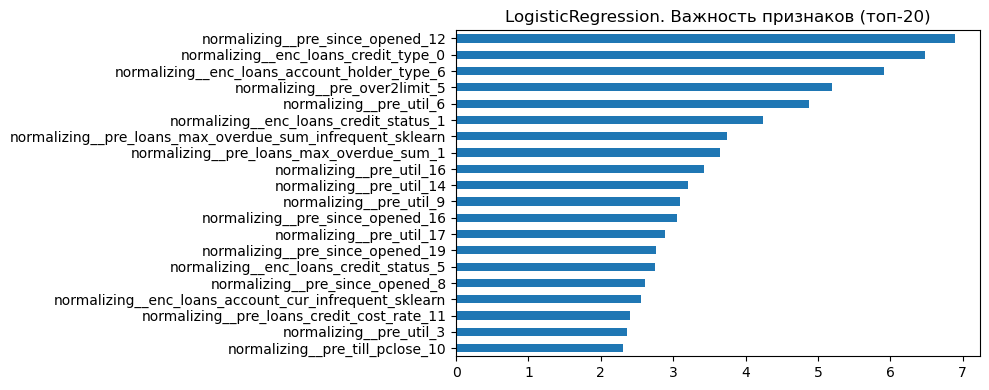

In [21]:
ax = logreg_importances[-20:].plot.barh(figsize=(10,4))
ax.set_title("LogisticRegression. Важность признаков (топ-20)")
ax.figure.tight_layout()

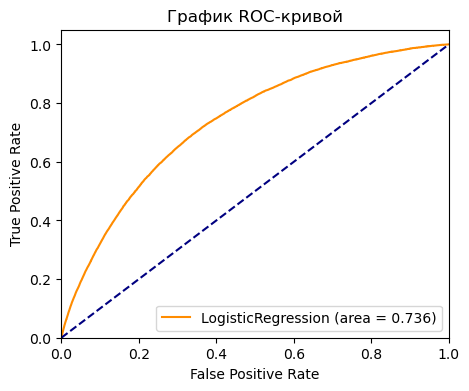

In [22]:
# Построение графика roc-кривой.
fpr_log, tpr_log, treshold_log = roc_curve(y_test, logreg_probs)
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize=(5, 4))
plt.plot(fpr_log, tpr_log, color='darkorange',
         label='LogisticRegression (area = %0.3f)' % roc_auc_log)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Функция "красивой" визуализации матрицы ошибок.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

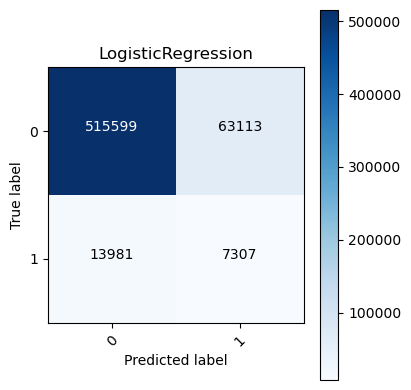

In [24]:
# Марица ошибок.

plot_confusion_matrix(confusion_matrix(y_test, logreg_pred_test), classes=['0','1'], title='LogisticRegression')

Матрица ошибок (при пороге принятия решений по умочанию, равным 0.5) выглядит удовлетворительно. Для кредитных кейсов часто большей ошибкой счиается одобрение кредита потенциальному банкроту, чем неодобрение кредита надежному клиенту. Метрика recall имеет приоритет. Поэтому точку порога принятия решений можно уменьшить для еще большего увеличения метрики recall (см график ниже). 

In [25]:
# Матрица сопряженности.

print(classification_report(y_test, logreg_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93    578712
           1       0.10      0.34      0.16     21288

    accuracy                           0.87    600000
   macro avg       0.54      0.62      0.54    600000
weighted avg       0.94      0.87      0.90    600000



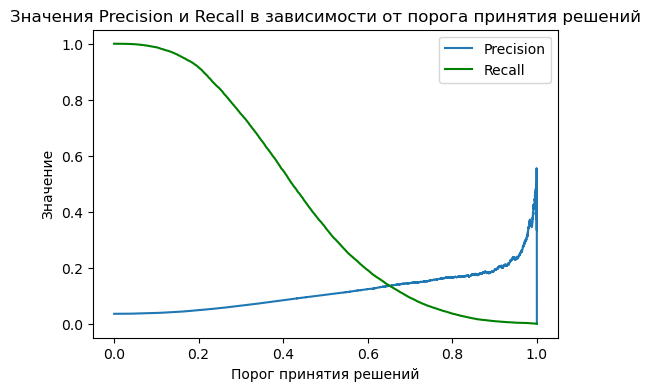

In [26]:
# Построения графика для анализа зависимости precision, recall и порога принятия решений.
precision, recall, threshold = precision_recall_curve(y_test, logreg_probs)

plt.figure(figsize=(6, 4))
plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], 'g-', label='Recall')
plt.ylabel('Значение')
plt.xlabel('Порог принятия решений')
plt.title('Значения Precision и Recall в зависимости от порога принятия решений')
plt.legend(loc='best')
plt.show()

## RandomForestClassifier

In [27]:
model = RandomForestClassifier(random_state=73)

In [28]:
# Функция удаления "айдишников".
def filter_data(df):
    df_temp = df.copy()
    columns_to_drop = ['id']

    return df_temp.drop(columns_to_drop, axis=1)

In [29]:
def new_features(df):
    df_temp = df.copy()
    df_temp['is_zero_loans_risk'] = df_temp[['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']].lt(0.6).sum(axis=1)
    df_temp['is_zero_loans_points'] = df_temp['is_zero_loans5']*1 + df_temp['is_zero_loans530']*1.5 + df_temp['is_zero_loans3060']*2 + df_temp['is_zero_loans6090']*2.5 + df_temp['is_zero_loans90']*3
    
    return df_temp

In [30]:
# Пайплайн-препроцессор новых фичей.
preprocessor = Pipeline(steps=[
    ('filter', FunctionTransformer(filter_data)),
    ('new_features', FunctionTransformer(new_features))])

In [ ]:
# В целях удобства и получения навыка работы с "облачными" технологиями данный код был запущен в сервисе Yandex DataSphere.

def objective(trial):    
    # Список гиперпараметров для перебора 
    
    params = {
        'max_depth': trial.suggest_int('max_depth', 15, 25),                # глубина дерева
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),        # количество деревьев
        'max_features': trial.suggest_int('max_features', 15, 30),          # количество признаков при поиске лучшего сплита
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 3),    # минимальное количество объектов в узле
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 4),  # минимальное количество объектов для сплита
        'class_weight': {0:1, 1:trial.suggest_int('class_weight', 1, 30)}   # балансировка весов классов
    }
                        
    
    model.set_params(**params)
    
    
    # Прикручиваем пайплайны. Для "случайного леса" в нормализации числовых признаков нет необходимости
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Кросс-валидация на четырех фолдах, каждый фолд и отложенная тест-выборка имеют размерность 600тыс строк
    score = cross_val_score(pipeline, X_train, y_train, cv=4, n_jobs=-1, scoring= 'roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize", pruner=HyperbandPruner)
study.optimize(objective, n_trials=100)

print('Лучшие гиперпараметры:', study.best_trial.params)
print('Лучшее значение roc-auc:', study.best_trial.value)

In [31]:
# Лучшая модель с соответствующими гиперпараметрами, полученными в результате выполнения предыдущей ячейки в облачном сервисе.
forest_best = RandomForestClassifier(max_depth=18, n_estimators=188, class_weight={0: 1, 1: 2}, max_features=22, 
                                     min_samples_leaf=3, min_samples_split=3, random_state=73)

In [32]:
forest_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', forest_best)
    ])

In [33]:
forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('filter',
                                  FunctionTransformer(func=<function filter_data at 0x000002DB874CCCC0>)),
                                 ('new_features',
                                  FunctionTransformer(func=<function new_features at 0x000002DB874CCE00>))])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=18,
                                        max_features=22, min_samples_leaf=3,
                                        min_samples_split=3, n_estimators=188,
                                        random_state=73))])

In [34]:
# Предсказание класса
forest_pred_test = forest_pipeline.predict(X_test)

In [35]:
# Предсказание вероятности принадлежности к классу
forest_probs = forest_pipeline.predict_proba(X_test)[:, 1]

In [36]:
print('Итоговая тюнингованная модель Случайного леса')
print('Значение roc_auc на тестовой выборке: ', round(roc_auc_score(y_test, forest_probs),4)) 

Итоговая тюнингованная модель Случайного леса
Значение roc_auc на тестовой выборке:  0.7448


In [37]:
forest_feature_names = forest_pipeline[1].feature_names_in_

forest_importances = pd.Series(forest_pipeline[1].feature_importances_, index=forest_feature_names).sort_values(ascending=True)

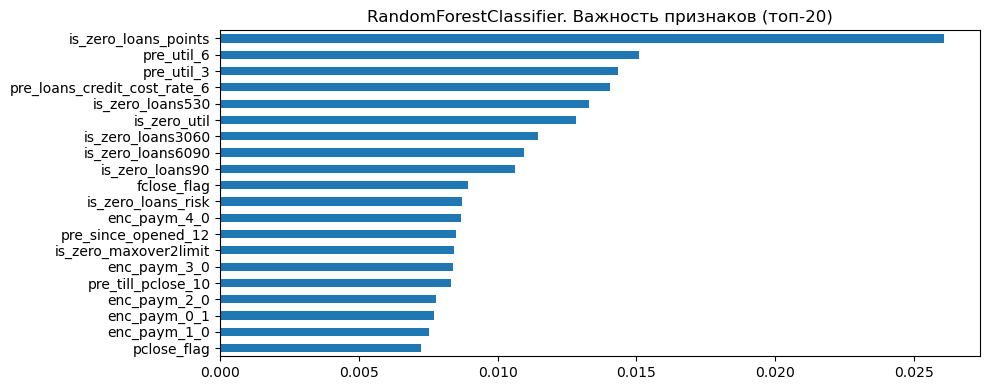

In [38]:
# Видим, что 1 и 11 строки занимают сгенерированные новые признаки.

ax = forest_importances[-20:].plot.barh(figsize=(10,4))
ax.set_title("RandomForestClassifier. Важность признаков (топ-20)")
ax.figure.tight_layout()

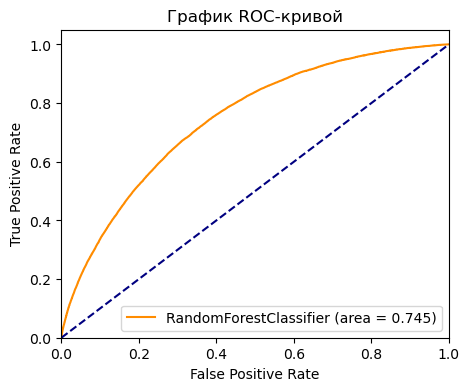

In [39]:
# Построение графика roc-кривой.
fpr_rf, tpr_rf, treshold_rf = roc_curve(y_test, forest_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(5, 4))
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         label='RandomForestClassifier (area = %0.3f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой')
plt.legend(loc="lower right")
plt.show()

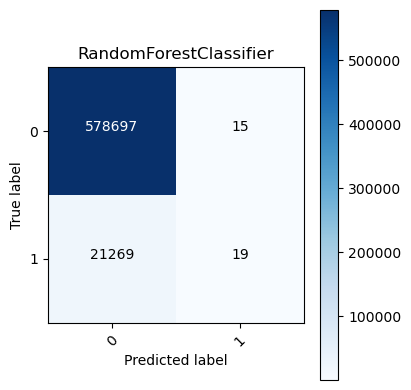

In [40]:
# Матрица ошибок выглядит неудовлетворительно. Модель определяетя только класс "0".
# Необходимо значительно снизить порог принятия решений для увеличения метрики recall (см. график ниже).

plot_confusion_matrix(confusion_matrix(y_test, forest_pred_test), classes=['0','1'], title='RandomForestClassifier')

In [41]:
# Матрица сопряженности.

print(classification_report(y_test, forest_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    578712
           1       0.56      0.00      0.00     21288

    accuracy                           0.96    600000
   macro avg       0.76      0.50      0.49    600000
weighted avg       0.95      0.96      0.95    600000



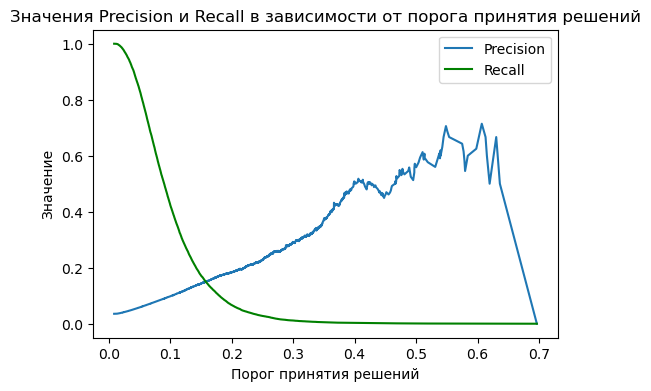

In [42]:
# Построения графика для анализа зависимости precision, recall и порога принятия решений.
precision, recall, threshold = precision_recall_curve(y_test, forest_probs)

plt.figure(figsize=(6, 4))
plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], 'g-', label='Recall')
plt.ylabel('Значение')
plt.xlabel('Порог принятия решений')
plt.title('Значения Precision и Recall в зависимости от порога принятия решений')
plt.legend(loc='best')
plt.show()

## CatBoostClassifier

In [43]:
model = CatBoostClassifier(random_seed=73)

In [44]:
# Функция удаления "айдишников".
def filter_data(df):
    df_temp = df.copy()
    columns_to_drop = ['id']

    return df_temp.drop(columns_to_drop, axis=1)

In [45]:
def new_features(df):
    df_temp = df.copy()
    df_temp['is_zero_loans_risk'] = df_temp[['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']].lt(0.6).sum(axis=1)
    df_temp['is_zero_loans_points'] = df_temp['is_zero_loans5']*1 + df_temp['is_zero_loans530']*1.5 + df_temp['is_zero_loans3060']*2 + df_temp['is_zero_loans6090']*2.5 + df_temp['is_zero_loans90']*3
    
    return df_temp

In [46]:
# Пайплайн-препроцессор новых фичей.
preprocessor = Pipeline(steps=[
    ('filter', FunctionTransformer(filter_data)),
    ('new_features', FunctionTransformer(new_features))])

In [ ]:
# В целях удобства и получения навыка работы с "облачными" технологиями данный код был запущен в сервисе Yandex DataSphere.

def objective(trial):    
    # Список гиперпараметров для перебора 
    
    params = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 40),
        "depth": trial.suggest_int("depth", 1, 12),
        }
                        
    
    model.set_params(**params)
    
    
    # Прикручиваем пайплайны. Для catboost в нормализации числовых признаков нет необходимости
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Кросс-валидация на четырех фолдах, каждый фолд и отложенная тест-выборка имеют размерность 600тыс строк
    score = cross_val_score(pipeline, X_train, y_train, cv=4, n_jobs=-1, scoring= 'roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize", pruner=HyperbandPruner)
study.optimize(objective, n_trials=100)

print('Лучшие гиперпараметры:', study.best_trial.params)
print('Лучшее значение roc-auc:', study.best_trial.value)

In [47]:
# Лучшая модель с соответствующими гиперпараметрами.
catboost_best = CatBoostClassifier(max_depth=9, objective='CrossEntropy', min_data_in_leaf=37, 
                                   learning_rate=0.06553798310275494, random_seed=73)

In [48]:
catboost_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', catboost_best)
    ])

In [49]:
catboost_pipeline.fit(X_train, y_train)

0:	learn: 0.5984712	total: 818ms	remaining: 13m 37s
1:	learn: 0.5194754	total: 1.67s	remaining: 13m 53s
2:	learn: 0.4550181	total: 2.42s	remaining: 13m 23s
3:	learn: 0.4019613	total: 3.22s	remaining: 13m 22s
4:	learn: 0.3581942	total: 3.99s	remaining: 13m 14s
5:	learn: 0.3217620	total: 4.59s	remaining: 12m 40s
6:	learn: 0.2917984	total: 5.25s	remaining: 12m 24s
7:	learn: 0.2671996	total: 6.28s	remaining: 12m 58s
8:	learn: 0.2481874	total: 6.93s	remaining: 12m 42s
9:	learn: 0.2320866	total: 7.58s	remaining: 12m 30s
10:	learn: 0.2183228	total: 8.38s	remaining: 12m 33s
11:	learn: 0.2068311	total: 9.15s	remaining: 12m 33s
12:	learn: 0.1969288	total: 10s	remaining: 12m 41s
13:	learn: 0.1887997	total: 10.8s	remaining: 12m 43s
14:	learn: 0.1821315	total: 11.6s	remaining: 12m 43s
15:	learn: 0.1765462	total: 12.3s	remaining: 12m 37s
16:	learn: 0.1717497	total: 13.2s	remaining: 12m 42s
17:	learn: 0.1675906	total: 14s	remaining: 12m 42s
18:	learn: 0.1642412	total: 14.8s	remaining: 12m 45s
19:	lea

154:	learn: 0.1369137	total: 2m 33s	remaining: 13m 56s
155:	learn: 0.1368870	total: 2m 34s	remaining: 13m 56s
156:	learn: 0.1368641	total: 2m 35s	remaining: 13m 56s
157:	learn: 0.1368515	total: 2m 36s	remaining: 13m 55s
158:	learn: 0.1368444	total: 2m 37s	remaining: 13m 53s
159:	learn: 0.1368314	total: 2m 38s	remaining: 13m 52s
160:	learn: 0.1368110	total: 2m 39s	remaining: 13m 51s
161:	learn: 0.1367961	total: 2m 40s	remaining: 13m 50s
162:	learn: 0.1367696	total: 2m 41s	remaining: 13m 49s
163:	learn: 0.1367549	total: 2m 42s	remaining: 13m 48s
164:	learn: 0.1367425	total: 2m 43s	remaining: 13m 47s
165:	learn: 0.1367309	total: 2m 44s	remaining: 13m 45s
166:	learn: 0.1367131	total: 2m 45s	remaining: 13m 44s
167:	learn: 0.1366992	total: 2m 46s	remaining: 13m 42s
168:	learn: 0.1366891	total: 2m 46s	remaining: 13m 40s
169:	learn: 0.1366713	total: 2m 47s	remaining: 13m 39s
170:	learn: 0.1366612	total: 2m 48s	remaining: 13m 37s
171:	learn: 0.1366551	total: 2m 49s	remaining: 13m 35s
172:	learn

305:	learn: 0.1351307	total: 4m 51s	remaining: 11m 1s
306:	learn: 0.1351151	total: 4m 52s	remaining: 11m 1s
307:	learn: 0.1351066	total: 4m 53s	remaining: 11m
308:	learn: 0.1350988	total: 4m 54s	remaining: 10m 58s
309:	learn: 0.1350849	total: 4m 55s	remaining: 10m 57s
310:	learn: 0.1350732	total: 4m 56s	remaining: 10m 56s
311:	learn: 0.1350637	total: 4m 57s	remaining: 10m 55s
312:	learn: 0.1350529	total: 4m 58s	remaining: 10m 54s
313:	learn: 0.1350386	total: 4m 59s	remaining: 10m 53s
314:	learn: 0.1350321	total: 5m	remaining: 10m 52s
315:	learn: 0.1350262	total: 5m	remaining: 10m 51s
316:	learn: 0.1350148	total: 5m 1s	remaining: 10m 50s
317:	learn: 0.1350051	total: 5m 2s	remaining: 10m 49s
318:	learn: 0.1350022	total: 5m 3s	remaining: 10m 47s
319:	learn: 0.1349973	total: 5m 4s	remaining: 10m 46s
320:	learn: 0.1349905	total: 5m 4s	remaining: 10m 45s
321:	learn: 0.1349841	total: 5m 5s	remaining: 10m 43s
322:	learn: 0.1349724	total: 5m 6s	remaining: 10m 42s
323:	learn: 0.1349680	total: 5m

458:	learn: 0.1338603	total: 7m 6s	remaining: 8m 22s
459:	learn: 0.1338529	total: 7m 7s	remaining: 8m 21s
460:	learn: 0.1338517	total: 7m 7s	remaining: 8m 20s
461:	learn: 0.1338467	total: 7m 8s	remaining: 8m 19s
462:	learn: 0.1338442	total: 7m 9s	remaining: 8m 17s
463:	learn: 0.1338325	total: 7m 10s	remaining: 8m 17s
464:	learn: 0.1338208	total: 7m 11s	remaining: 8m 16s
465:	learn: 0.1338132	total: 7m 12s	remaining: 8m 15s
466:	learn: 0.1338087	total: 7m 13s	remaining: 8m 14s
467:	learn: 0.1337994	total: 7m 14s	remaining: 8m 13s
468:	learn: 0.1337895	total: 7m 15s	remaining: 8m 12s
469:	learn: 0.1337819	total: 7m 16s	remaining: 8m 11s
470:	learn: 0.1337743	total: 7m 17s	remaining: 8m 10s
471:	learn: 0.1337696	total: 7m 17s	remaining: 8m 9s
472:	learn: 0.1337620	total: 7m 18s	remaining: 8m 8s
473:	learn: 0.1337537	total: 7m 19s	remaining: 8m 7s
474:	learn: 0.1337506	total: 7m 20s	remaining: 8m 6s
475:	learn: 0.1337475	total: 7m 20s	remaining: 8m 5s
476:	learn: 0.1337433	total: 7m 21s	re

612:	learn: 0.1327921	total: 9m 19s	remaining: 5m 53s
613:	learn: 0.1327833	total: 9m 20s	remaining: 5m 52s
614:	learn: 0.1327791	total: 9m 21s	remaining: 5m 51s
615:	learn: 0.1327695	total: 9m 22s	remaining: 5m 50s
616:	learn: 0.1327656	total: 9m 23s	remaining: 5m 49s
617:	learn: 0.1327574	total: 9m 23s	remaining: 5m 48s
618:	learn: 0.1327496	total: 9m 24s	remaining: 5m 47s
619:	learn: 0.1327374	total: 9m 25s	remaining: 5m 46s
620:	learn: 0.1327335	total: 9m 26s	remaining: 5m 45s
621:	learn: 0.1327264	total: 9m 27s	remaining: 5m 44s
622:	learn: 0.1327164	total: 9m 28s	remaining: 5m 44s
623:	learn: 0.1327096	total: 9m 29s	remaining: 5m 43s
624:	learn: 0.1327017	total: 9m 30s	remaining: 5m 42s
625:	learn: 0.1326988	total: 9m 31s	remaining: 5m 41s
626:	learn: 0.1326953	total: 9m 31s	remaining: 5m 40s
627:	learn: 0.1326899	total: 9m 32s	remaining: 5m 39s
628:	learn: 0.1326848	total: 9m 33s	remaining: 5m 38s
629:	learn: 0.1326807	total: 9m 34s	remaining: 5m 37s
630:	learn: 0.1326723	total:

763:	learn: 0.1317908	total: 11m 31s	remaining: 3m 33s
764:	learn: 0.1317838	total: 11m 32s	remaining: 3m 32s
765:	learn: 0.1317803	total: 11m 33s	remaining: 3m 31s
766:	learn: 0.1317725	total: 11m 33s	remaining: 3m 30s
767:	learn: 0.1317685	total: 11m 34s	remaining: 3m 29s
768:	learn: 0.1317520	total: 11m 35s	remaining: 3m 29s
769:	learn: 0.1317480	total: 11m 36s	remaining: 3m 28s
770:	learn: 0.1317404	total: 11m 37s	remaining: 3m 27s
771:	learn: 0.1317312	total: 11m 38s	remaining: 3m 26s
772:	learn: 0.1317290	total: 11m 39s	remaining: 3m 25s
773:	learn: 0.1317249	total: 11m 40s	remaining: 3m 24s
774:	learn: 0.1317178	total: 11m 40s	remaining: 3m 23s
775:	learn: 0.1317150	total: 11m 41s	remaining: 3m 22s
776:	learn: 0.1317126	total: 11m 42s	remaining: 3m 21s
777:	learn: 0.1317075	total: 11m 43s	remaining: 3m 20s
778:	learn: 0.1317001	total: 11m 44s	remaining: 3m 19s
779:	learn: 0.1316955	total: 11m 44s	remaining: 3m 18s
780:	learn: 0.1316889	total: 11m 45s	remaining: 3m 17s
781:	learn

913:	learn: 0.1308567	total: 13m 41s	remaining: 1m 17s
914:	learn: 0.1308554	total: 13m 42s	remaining: 1m 16s
915:	learn: 0.1308483	total: 13m 43s	remaining: 1m 15s
916:	learn: 0.1308417	total: 13m 44s	remaining: 1m 14s
917:	learn: 0.1308377	total: 13m 44s	remaining: 1m 13s
918:	learn: 0.1308322	total: 13m 45s	remaining: 1m 12s
919:	learn: 0.1308279	total: 13m 46s	remaining: 1m 11s
920:	learn: 0.1308207	total: 13m 47s	remaining: 1m 10s
921:	learn: 0.1308103	total: 13m 48s	remaining: 1m 10s
922:	learn: 0.1308037	total: 13m 49s	remaining: 1m 9s
923:	learn: 0.1307952	total: 13m 50s	remaining: 1m 8s
924:	learn: 0.1307922	total: 13m 51s	remaining: 1m 7s
925:	learn: 0.1307895	total: 13m 51s	remaining: 1m 6s
926:	learn: 0.1307830	total: 13m 52s	remaining: 1m 5s
927:	learn: 0.1307769	total: 13m 53s	remaining: 1m 4s
928:	learn: 0.1307681	total: 13m 54s	remaining: 1m 3s
929:	learn: 0.1307659	total: 13m 55s	remaining: 1m 2s
930:	learn: 0.1307626	total: 13m 56s	remaining: 1m 1s
931:	learn: 0.13076

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('filter',
                                  FunctionTransformer(func=<function filter_data at 0x000002DB8C2576A0>)),
                                 ('new_features',
                                  FunctionTransformer(func=<function new_features at 0x000002DB874CF4C0>))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002DB874F5750>)])

In [50]:
# Предсказание класса
catboost_pred_test = catboost_pipeline.predict(X_test)

In [51]:
# Предсказание вероятности принадлежности к классу
catboost_probs = catboost_pipeline.predict_proba(X_test)[:, 1]

In [52]:
print('Итоговая тюнингованная модель CatBoostClassifier')
print('Значение roc_auc на тестовой выборке: ', round(roc_auc_score(y_test, catboost_probs),4)) 

Итоговая тюнингованная модель CatBoostClassifier
Значение roc_auc на тестовой выборке:  0.7604


In [53]:
catboost_feature_names = catboost_pipeline[1].feature_names_

catboost_importances = pd.Series(catboost_pipeline[1].feature_importances_, index=catboost_feature_names).sort_values(ascending=True)

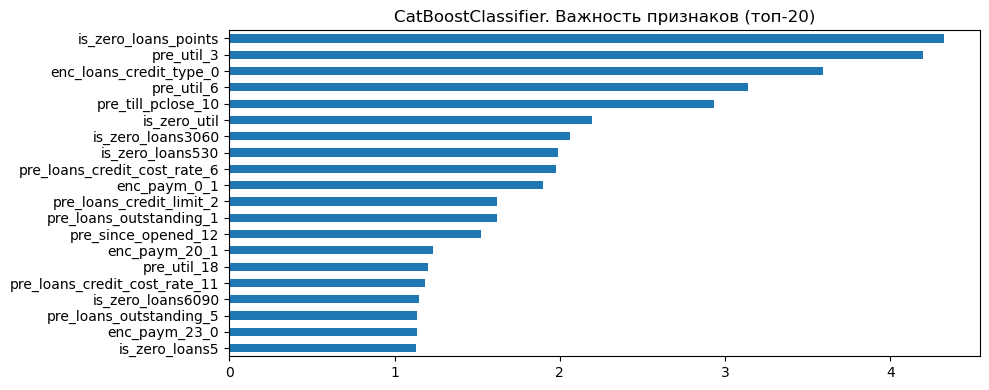

In [54]:
# И у этой модели наболее важным является новый сгенерированный признак "веса тяжести"

ax = catboost_importances[-20:].plot.barh(figsize=(10,4))
ax.set_title("CatBoostClassifier. Важность признаков (топ-20)")
ax.figure.tight_layout()

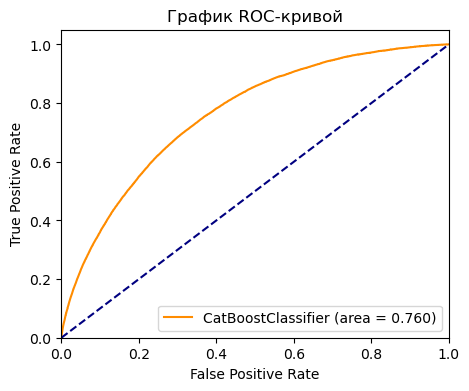

In [55]:
# Построение графика roc-кривой.
fpr_cat, tpr_cat, treshold_cat = roc_curve(y_test, catboost_probs)
roc_auc_cat = auc(fpr_cat, tpr_cat)

plt.figure(figsize=(5, 4))
plt.plot(fpr_cat, tpr_cat, color='darkorange',
         label='CatBoostClassifier (area = %0.3f)' % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой')
plt.legend(loc="lower right")
plt.show()

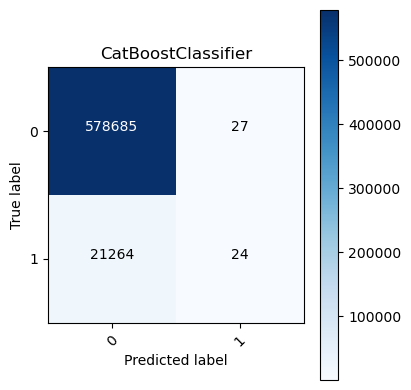

In [56]:
# Также перед сдачей модели в производство потребуется регулировка порога принятия решений в сторону уменьшения.

plot_confusion_matrix(confusion_matrix(y_test, catboost_pred_test), classes=['0','1'], title='CatBoostClassifier')

In [57]:
# Матрица сопряженности.

print(classification_report(y_test, catboost_pred_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    578712
           1       0.47      0.00      0.00     21288

    accuracy                           0.96    600000
   macro avg       0.72      0.50      0.49    600000
weighted avg       0.95      0.96      0.95    600000



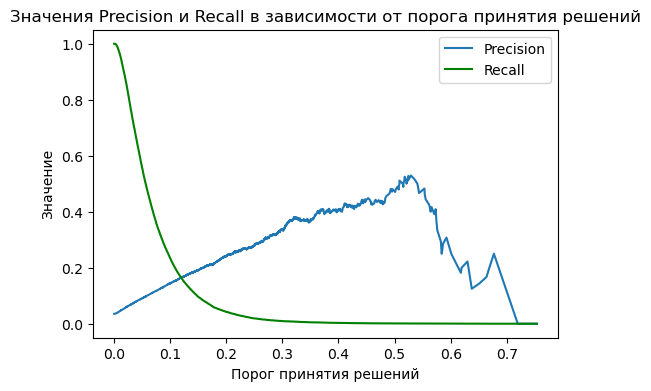

In [58]:
# Построения графика для анализа зависимости precision, recall и порога принятия решений.
precision, recall, threshold = precision_recall_curve(y_test, catboost_probs)

plt.figure(figsize=(6, 4))
plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], 'g-', label='Recall')
plt.ylabel('Значение')
plt.xlabel('Порог принятия решений')
plt.title('Значения Precision и Recall в зависимости от порога принятия решений')
plt.legend(loc='best')
plt.show()

## Итоги. Пайплайн с лучшей моделью.

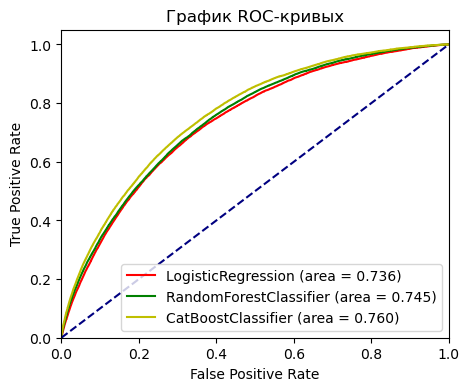

In [59]:
plt.figure(figsize=(5, 4))
plt.plot(fpr_log, tpr_log, color='r', label='LogisticRegression (area = %0.3f)' % roc_auc_log)
plt.plot(fpr_rf, tpr_rf, color='g', label='RandomForestClassifier (area = %0.3f)' % roc_auc_rf)
plt.plot(fpr_cat, tpr_cat, color='y', label='CatBoostClassifier (area = %0.3f)' % roc_auc_cat)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривых')
plt.legend(loc="lower right")
plt.show()

In [60]:
# Финальные результаты

data_final = pd.DataFrame({'base, cross-val на трейне (2.4 строк)':[0.733,0.704,0.7592],
                     'тюнинг, cross-val на трейне (2.4 млн строк)':[0.7378,0.748,0.7639],
                     'финал на тесте 0.6 млн строк':[0.736,0.7448,0.7604]},
                     index=['LogisticRegression','RandomForestClassifier','CatBoostClassifier'])
data_final

,"base, cross-val на трейне (2.4 строк)","тюнинг, cross-val на трейне (2.4 млн строк)",финал на тесте 0.6 млн строк
LogisticRegression,0.7330,0.7378,0.7360
RandomForestClassifier,0.7040,0.7480,0.7448
CatBoostClassifier,0.7592,0.7639,0.7604


**МОДЕЛЬ ПОБЕДИТЕЛЬ - CatBoostClassifier**

**Результат на отложенной тестовой выборке - 0.7604**

In [61]:
# Предсказания лучшей модели на тест-выборке.
test_submission = pd.DataFrame(data = {
    'id': X_test['id'],
    'predictions': catboost_pred_test
})

test_submission.head()

,id,predictions
795562,795562,0
2864923,2864923,0
1178692,1178692,0
342417,342417,0
1737803,1737803,0


In [62]:
# Сохраниние пресказаний в файл.
test_submission.to_csv('test_submission.csv')

#### Сохраниение пайплайна с лучшей моделью

In [63]:
# Функция удаления "айдишников".
def filter_data(df):
    df_temp = df.copy()
    columns_to_drop = ['id']

    return df_temp.drop(columns_to_drop, axis=1)

In [64]:
# Функция создания новых признаков.
def new_features(df):
    df_temp = df.copy()
    df_temp['is_zero_loans_risk'] = df_temp[['is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090', 'is_zero_loans90']].lt(0.6).sum(axis=1)
    df_temp['is_zero_loans_points'] = df_temp['is_zero_loans5']*1 + df_temp['is_zero_loans530']*1.5 + df_temp['is_zero_loans3060']*2 + df_temp['is_zero_loans6090']*2.5 + df_temp['is_zero_loans90']*3
    
    return df_temp

In [65]:
# Пайплайн-препроцессор новых фичей.
preprocessor = Pipeline(steps=[
    ('filter', FunctionTransformer(filter_data)),
    ('new_features', FunctionTransformer(new_features))])

In [66]:
# Лучшая модель с соответствующими гиперпараметрами.
catboost_best = CatBoostClassifier(max_depth=9, objective='CrossEntropy', min_data_in_leaf=37, 
                                   learning_rate=0.06553798310275494, random_seed=73)

In [67]:
catboost_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', catboost_best)
    ])

In [68]:
# Обучение пайплайна на всех 3 млн данных.
catboost_pipeline.fit(X,y)

0:	learn: 0.5967905	total: 983ms	remaining: 16m 22s
1:	learn: 0.5182063	total: 1.76s	remaining: 14m 37s
2:	learn: 0.4537837	total: 2.64s	remaining: 14m 38s
3:	learn: 0.4012799	total: 3.47s	remaining: 14m 24s
4:	learn: 0.3579789	total: 4.2s	remaining: 13m 56s
5:	learn: 0.3213662	total: 5.13s	remaining: 14m 10s
6:	learn: 0.2919773	total: 6.2s	remaining: 14m 39s
7:	learn: 0.2675430	total: 7.29s	remaining: 15m 3s
8:	learn: 0.2482595	total: 7.96s	remaining: 14m 36s
9:	learn: 0.2318274	total: 8.79s	remaining: 14m 30s
10:	learn: 0.2178963	total: 9.83s	remaining: 14m 43s
11:	learn: 0.2068408	total: 10.6s	remaining: 14m 33s
12:	learn: 0.1964336	total: 11.9s	remaining: 15m 5s
13:	learn: 0.1883437	total: 13.1s	remaining: 15m 20s
14:	learn: 0.1819157	total: 13.9s	remaining: 15m 15s
15:	learn: 0.1763126	total: 15s	remaining: 15m 21s
16:	learn: 0.1714260	total: 16s	remaining: 15m 25s
17:	learn: 0.1670944	total: 17.2s	remaining: 15m 37s
18:	learn: 0.1636311	total: 18.3s	remaining: 15m 47s
19:	learn: 

154:	learn: 0.1372120	total: 3m 10s	remaining: 17m 20s
155:	learn: 0.1371939	total: 3m 12s	remaining: 17m 20s
156:	learn: 0.1371825	total: 3m 13s	remaining: 17m 17s
157:	learn: 0.1371624	total: 3m 14s	remaining: 17m 16s
158:	learn: 0.1371523	total: 3m 15s	remaining: 17m 14s
159:	learn: 0.1371306	total: 3m 16s	remaining: 17m 14s
160:	learn: 0.1371156	total: 3m 18s	remaining: 17m 13s
161:	learn: 0.1371048	total: 3m 19s	remaining: 17m 11s
162:	learn: 0.1370900	total: 3m 20s	remaining: 17m 10s
163:	learn: 0.1370783	total: 3m 22s	remaining: 17m 9s
164:	learn: 0.1370592	total: 3m 23s	remaining: 17m 8s
165:	learn: 0.1370504	total: 3m 24s	remaining: 17m 7s
166:	learn: 0.1370376	total: 3m 25s	remaining: 17m 6s
167:	learn: 0.1370178	total: 3m 27s	remaining: 17m 5s
168:	learn: 0.1370064	total: 3m 28s	remaining: 17m 3s
169:	learn: 0.1369948	total: 3m 29s	remaining: 17m 2s
170:	learn: 0.1369831	total: 3m 30s	remaining: 17m
171:	learn: 0.1369669	total: 3m 31s	remaining: 17m
172:	learn: 0.1369599	tot

305:	learn: 0.1355721	total: 6m 7s	remaining: 13m 53s
306:	learn: 0.1355547	total: 6m 8s	remaining: 13m 51s
307:	learn: 0.1355504	total: 6m 9s	remaining: 13m 50s
308:	learn: 0.1355468	total: 6m 10s	remaining: 13m 48s
309:	learn: 0.1355392	total: 6m 11s	remaining: 13m 46s
310:	learn: 0.1355306	total: 6m 12s	remaining: 13m 45s
311:	learn: 0.1355226	total: 6m 13s	remaining: 13m 43s
312:	learn: 0.1355079	total: 6m 14s	remaining: 13m 42s
313:	learn: 0.1355021	total: 6m 15s	remaining: 13m 40s
314:	learn: 0.1354890	total: 6m 17s	remaining: 13m 40s
315:	learn: 0.1354822	total: 6m 18s	remaining: 13m 38s
316:	learn: 0.1354711	total: 6m 19s	remaining: 13m 37s
317:	learn: 0.1354645	total: 6m 20s	remaining: 13m 36s
318:	learn: 0.1354583	total: 6m 21s	remaining: 13m 34s
319:	learn: 0.1354470	total: 6m 22s	remaining: 13m 33s
320:	learn: 0.1354428	total: 6m 24s	remaining: 13m 32s
321:	learn: 0.1354355	total: 6m 25s	remaining: 13m 30s
322:	learn: 0.1354300	total: 6m 25s	remaining: 13m 28s
323:	learn: 0

456:	learn: 0.1344415	total: 8m 54s	remaining: 10m 34s
457:	learn: 0.1344327	total: 8m 55s	remaining: 10m 33s
458:	learn: 0.1344201	total: 8m 57s	remaining: 10m 33s
459:	learn: 0.1344120	total: 8m 58s	remaining: 10m 31s
460:	learn: 0.1344091	total: 8m 59s	remaining: 10m 30s
461:	learn: 0.1344016	total: 9m	remaining: 10m 29s
462:	learn: 0.1343966	total: 9m 1s	remaining: 10m 28s
463:	learn: 0.1343906	total: 9m 2s	remaining: 10m 26s
464:	learn: 0.1343856	total: 9m 3s	remaining: 10m 25s
465:	learn: 0.1343834	total: 9m 4s	remaining: 10m 23s
466:	learn: 0.1343799	total: 9m 5s	remaining: 10m 22s
467:	learn: 0.1343746	total: 9m 6s	remaining: 10m 20s
468:	learn: 0.1343716	total: 9m 7s	remaining: 10m 19s
469:	learn: 0.1343638	total: 9m 8s	remaining: 10m 18s
470:	learn: 0.1343579	total: 9m 9s	remaining: 10m 17s
471:	learn: 0.1343501	total: 9m 10s	remaining: 10m 16s
472:	learn: 0.1343471	total: 9m 11s	remaining: 10m 14s
473:	learn: 0.1343425	total: 9m 13s	remaining: 10m 13s
474:	learn: 0.1343366	t

607:	learn: 0.1334943	total: 11m 43s	remaining: 7m 33s
608:	learn: 0.1334876	total: 11m 44s	remaining: 7m 32s
609:	learn: 0.1334846	total: 11m 45s	remaining: 7m 31s
610:	learn: 0.1334823	total: 11m 46s	remaining: 7m 30s
611:	learn: 0.1334712	total: 11m 48s	remaining: 7m 28s
612:	learn: 0.1334676	total: 11m 49s	remaining: 7m 27s
613:	learn: 0.1334628	total: 11m 50s	remaining: 7m 26s
614:	learn: 0.1334604	total: 11m 50s	remaining: 7m 25s
615:	learn: 0.1334575	total: 11m 51s	remaining: 7m 23s
616:	learn: 0.1334520	total: 11m 52s	remaining: 7m 22s
617:	learn: 0.1334453	total: 11m 53s	remaining: 7m 21s
618:	learn: 0.1334413	total: 11m 54s	remaining: 7m 19s
619:	learn: 0.1334265	total: 11m 55s	remaining: 7m 18s
620:	learn: 0.1334232	total: 11m 56s	remaining: 7m 17s
621:	learn: 0.1334204	total: 11m 57s	remaining: 7m 16s
622:	learn: 0.1334111	total: 11m 59s	remaining: 7m 15s
623:	learn: 0.1334065	total: 12m	remaining: 7m 13s
624:	learn: 0.1333999	total: 12m 1s	remaining: 7m 12s
625:	learn: 0.1

758:	learn: 0.1326113	total: 14m 29s	remaining: 4m 36s
759:	learn: 0.1326053	total: 14m 30s	remaining: 4m 35s
760:	learn: 0.1325987	total: 14m 32s	remaining: 4m 33s
761:	learn: 0.1325957	total: 14m 33s	remaining: 4m 32s
762:	learn: 0.1325880	total: 14m 34s	remaining: 4m 31s
763:	learn: 0.1325827	total: 14m 35s	remaining: 4m 30s
764:	learn: 0.1325712	total: 14m 37s	remaining: 4m 29s
765:	learn: 0.1325634	total: 14m 38s	remaining: 4m 28s
766:	learn: 0.1325500	total: 14m 39s	remaining: 4m 27s
767:	learn: 0.1325462	total: 14m 40s	remaining: 4m 25s
768:	learn: 0.1325429	total: 14m 41s	remaining: 4m 24s
769:	learn: 0.1325335	total: 14m 42s	remaining: 4m 23s
770:	learn: 0.1325265	total: 14m 43s	remaining: 4m 22s
771:	learn: 0.1325200	total: 14m 44s	remaining: 4m 21s
772:	learn: 0.1325150	total: 14m 46s	remaining: 4m 20s
773:	learn: 0.1325132	total: 14m 46s	remaining: 4m 18s
774:	learn: 0.1325060	total: 14m 47s	remaining: 4m 17s
775:	learn: 0.1325013	total: 14m 49s	remaining: 4m 16s
776:	learn

909:	learn: 0.1318008	total: 17m 10s	remaining: 1m 41s
910:	learn: 0.1317939	total: 17m 11s	remaining: 1m 40s
911:	learn: 0.1317886	total: 17m 12s	remaining: 1m 39s
912:	learn: 0.1317832	total: 17m 14s	remaining: 1m 38s
913:	learn: 0.1317771	total: 17m 15s	remaining: 1m 37s
914:	learn: 0.1317667	total: 17m 16s	remaining: 1m 36s
915:	learn: 0.1317571	total: 17m 17s	remaining: 1m 35s
916:	learn: 0.1317552	total: 17m 18s	remaining: 1m 34s
917:	learn: 0.1317535	total: 17m 19s	remaining: 1m 32s
918:	learn: 0.1317484	total: 17m 20s	remaining: 1m 31s
919:	learn: 0.1317448	total: 17m 21s	remaining: 1m 30s
920:	learn: 0.1317360	total: 17m 22s	remaining: 1m 29s
921:	learn: 0.1317335	total: 17m 23s	remaining: 1m 28s
922:	learn: 0.1317273	total: 17m 24s	remaining: 1m 27s
923:	learn: 0.1317209	total: 17m 25s	remaining: 1m 26s
924:	learn: 0.1317120	total: 17m 27s	remaining: 1m 24s
925:	learn: 0.1317075	total: 17m 28s	remaining: 1m 23s
926:	learn: 0.1317035	total: 17m 29s	remaining: 1m 22s
927:	learn

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('filter',
                                  FunctionTransformer(func=<function filter_data at 0x000002DB8BC259E0>)),
                                 ('new_features',
                                  FunctionTransformer(func=<function new_features at 0x000002DB8BC25300>))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002DB8BC2AA90>)])

In [69]:
# Сохранение пайплайна в pickle-файл.

with open('credit_risk_pipeline.pkl', 'wb') as file:
    dill.dump({
        'model': catboost_pipeline,
        'metadata': {
            'name': 'Credit risk mamagement model',
            'author': 'Aleksey Pihuleuski',
            'version': 1,
            'date': '20.12.2023',
        }
    }, file)